### Detecting_Natural_Disaster_Changing_Softmax

In this Notebook we will train last softmax layer to detect natural disaster using VGG16 Model

In [12]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import plot_confusion_matrix
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model

In [13]:
train_data_dir = './data/train'
valid_data_dir = './data/validation'
test_data_dir = './data/test'

In [14]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=10,
        classes=['earthquake','fire','flood'])  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        valid_data_dir,
        target_size=(224, 224),
        batch_size=10,
        classes=['earthquake','fire','flood'])   #class_mode='binary') then either 0 or 1
# this is a similar generator, for test data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir,
        target_size=(224, 224),
        batch_size=10,
        classes=['earthquake','fire','flood'])   #class_mode='binary') then either 0 or 1

Found 4039 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [15]:
# dimensions of our images.
img_width, img_height = 150, 150
nb_train_samples = 2000
nb_validation_samples = 1000
batch_size = 40

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
print(input_shape,'input_shape')

(150, 150, 3) input_shape


In [16]:
print(train_generator.class_indices)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{'earthquake': 0, 'fire': 1, 'flood': 2}
{0: 'earthquake', 1: 'fire', 2: 'flood'}


In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

403 3


In [18]:
model = keras.applications.vgg16.VGG16()

In [19]:
last_layer = model.get_layer('fc2').output
#x= Flatten(name='flatten')(last_layer)
out = Dense(3, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(model.input, out)
custom_vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable=False

In [21]:
custom_vgg_model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
custom_vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
custom_vgg_model.fit_generator(generator=train_generator,validation_data=valid_generator,\
                    steps_per_epoch=STEP_SIZE_TRAIN,validation_steps=STEP_SIZE_VALID,verbose=1,epochs=5,)

Epoch 1/5
403/403 [==============================] - 2196s 5s/step - loss: 0.5049 - accuracy: 0.7898 - val_loss: 0.1144 - val_accuracy: 0.9333
Epoch 2/5
403/403 [==============================] - 2054s 5s/step - loss: 0.3406 - accuracy: 0.8610 - val_loss: 0.1410 - val_accuracy: 1.0000
Epoch 3/5
403/403 [==============================] - 2108s 5s/step - loss: 0.2876 - accuracy: 0.8833 - val_loss: 0.2855 - val_accuracy: 0.9091
Epoch 4/5
403/403 [==============================] - 2190s 5s/step - loss: 0.2651 - accuracy: 0.8891 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 5/5
403/403 [==============================] - 2075s 5s/step - loss: 0.2262 - accuracy: 0.9102 - val_loss: 0.1234 - val_accuracy: 0.9667


In [ ]:
model.save_weights('./model_weight/classiferModel_swap_softmax.h5') 

In [ ]:
test_img,test_labels=next(test_generator)
pred=custom_vgg_model.predict_generator(test_generator,
steps=1,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
test_labels_indices=np.argmax(test_labels,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
test_labes=[labels[k] for k in test_labels_indices]

1/1 [==============================] - 5s 5s/step


In [ ]:
print(classification_report(test_labes,predictions))

              precision    recall  f1-score   support

  earthquake       1.00      0.75      0.86         4
        fire       1.00      1.00      1.00         3
       flood       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.92      0.92      0.90        10
weighted avg       0.93      0.90      0.90        10



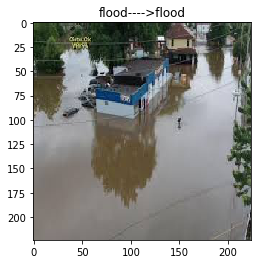

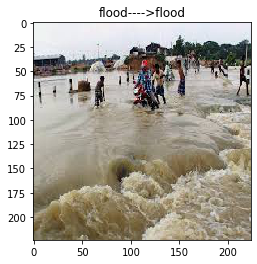

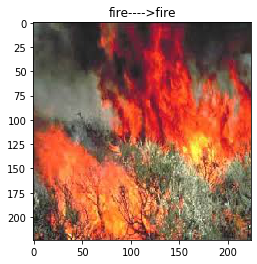

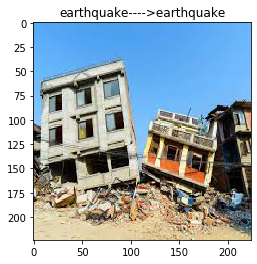

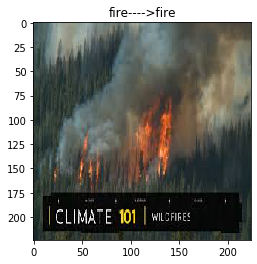

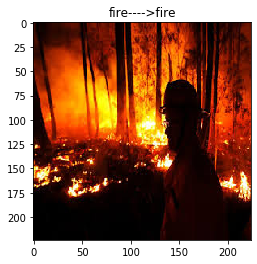

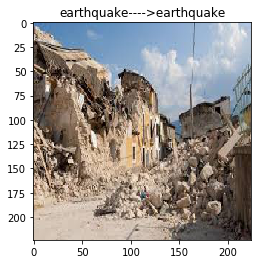

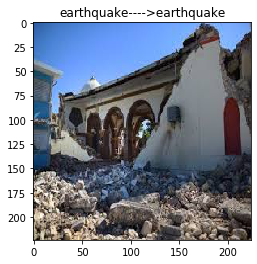

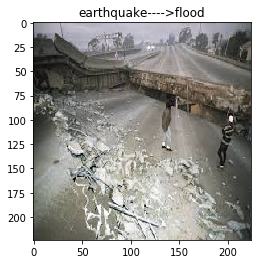

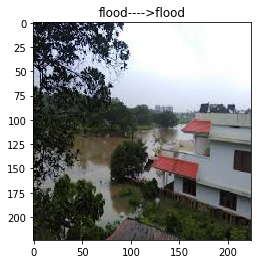

In [ ]:
predictions
for i in range(10):
    plt.imshow(test_img[i])
    plt.title(test_labes[i]+'---->'+predictions[i])
    plt.show()